In [1]:
import sys
from pathlib import Path
from matplotlib import animation, rc
from IPython.display import HTML
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.animation import FuncAnimation
from matplotlib import cm
from time import sleep, perf_counter as timer
from umap import UMAP
from sys import stderr
import matplotlib.pyplot as plt
import numpy as np
from rich.progress import track
sys.path.append("Resemblyzer")
from resemblyzer import preprocess_wav, VoiceEncoder, sampling_rate
from demo_utils import *

_default_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
_my_colors = np.array([
    [0, 127, 70],
    [255, 0, 0],
    [255, 217, 38],
    [0, 135, 255],
    [165, 0, 165],
    [255, 167, 255],
    [97, 142, 151],
    [0, 255, 255],
    [255, 96, 38],
    [142, 76, 0],
    [33, 0, 127],
    [0, 0, 0],
    [183, 183, 183],
    [76, 255, 0],
], dtype=np.float) / 255 


In [2]:

embed_rate = 5

wav_fpath = Path("Resemblyzer/audio_data", "X2zqiX6yL3I.mp3")
wav = preprocess_wav(wav_fpath)

encoder = VoiceEncoder("cpu")

# Cut some segments from single speakers as reference audio
segments = [[0, 5.5], [6.5, 12], [17, 25]]
speaker_names = ["Kyle Gass", "Sean Evans", "Jack Black"]
speaker_wavs = [wav[int(s[0] * sampling_rate):int(s[1] * sampling_rate)] for s in segments]
speaker_embeds = [encoder.embed_utterance(speaker_wav, rate=embed_rate) for speaker_wav in speaker_wavs]


print("Running the continuous embedding on cpu, this might take a while...")
_, cont_embeds, wav_splits = encoder.embed_utterance(wav, return_partials=True, rate=embed_rate)


similarity_dict = {name: cont_embeds @ speaker_embed for name, speaker_embed in 
                   zip(speaker_names, speaker_embeds)}

/Users/brauliorios/.pyenv/versions/3.7.6/envs/audio/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Loaded the voice encoder model on cpu in 0.01 seconds.
Running the continuous embedding on cpu, this might take a while...


In [4]:
def interactive_diarization(similarity_dict, wav_splits, x_crop=5, show_time=False):
    fig, ax = plt.subplots(figsize=(10, 5))
    lines = [ax.plot([], [], label=name)[0] for name in similarity_dict.keys()]
    text = ax.text(0, 0, "", fontsize=10)
    rich_iter = track(range(len(wav_splits)))
    
    def init():
        ax.set_ylim(0.4, 1.1)
        ax.set_ylabel("Similarity")
        if show_time:
            ax.set_xlabel("Time (seconds)")
        else:
            ax.set_xticks([])
        ax.set_title("Diarization")
        ax.legend(loc="lower right")
        return lines + [text]
    
    times = [((s.start + s.stop) / 2) / sampling_rate for s in wav_splits]
    rate = 1 / (times[1] - times[0])
    crop_range = int(np.round(x_crop * rate))
    ticks = np.arange(0, len(wav_splits), rate)
    ref_time = timer()
    
    def update(i):
        next(rich_iter)
        # Crop plot
        crop = (max(i - crop_range // 2, 0), i + crop_range // 2)
        ax.set_xlim(i - crop_range // 2, crop[1])
        if show_time:
            crop_ticks = ticks[(crop[0] <= ticks) * (ticks <= crop[1])]
            ax.set_xticks(crop_ticks)
            ax.set_xticklabels(np.round(crop_ticks / rate).astype(np.int))

        # Plot the prediction
        similarities = [s[i] for s in similarity_dict.values()]
        best = np.argmax(similarities)
        name, similarity = list(similarity_dict.keys())[best], similarities[best]
        if similarity > 0.75:
            message = "Speaker: %s (confident)" % name
            color = _default_colors[best]
        elif similarity > 0.65:
            message = "Speaker: %s (uncertain)" % name
            color = _default_colors[best]
        else:
            message = "Unknown/No speaker"
            color = "black"
        text.set_text(message)
        text.set_c(color)
        text.set_position((i, 0.96))
        
        # Plot data
        for line, (name, similarities) in zip(lines, similarity_dict.items()):
            line.set_data(range(crop[0], i + 1), similarities[crop[0]:i + 1])
        
        return lines + [text]
    
    ani = FuncAnimation(fig, update, frames=len(wav_splits), init_func=init, blit=not show_time,
                        repeat=False, interval=int(1000/embed_rate))
    rc('animation', html='html5')
    return ani


Output()

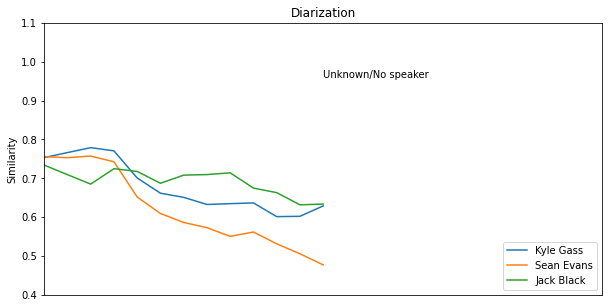

In [5]:
interactive_diarization(similarity_dict, wav_splits)

In [3]:
print(f"Starting in... ", end='')

for t in (3, 2, 1):
    print(f"{t} ", end='')
    sleep(1)
print("START")
play_wav(wav, blocking=False)

Starting in... 3 2 1 START


In [4]:
wav_speaker_1 = preprocess_wav("easy_speaker_1.wav")
wav_speaker_2 = preprocess_wav("easy_speaker_2.wav")
wav_both_speakers = preprocess_wav("easy.wav")

"""
### Calculate embeddings: Mel energies + LSTM + Linear layer
"""
encoder = VoiceEncoder("cpu")
embed_speaker_1 = encoder.embed_utterance(wav_speaker_1, rate=embed_rate)
embed_speaker_2 = encoder.embed_utterance(wav_speaker_2, rate=embed_rate)
_, cont_embeds, wav_splits = encoder.embed_utterance(wav_both_speakers, return_partials=True, rate=embed_rate)



# Cut some segments from single speakers as reference audio
speaker_names = ["Singer 1", "Singer 2"]
speaker_embeds = [embed_speaker_1, embed_speaker_2]


similarity_dict = {name: cont_embeds @ speaker_embed for name, speaker_embed in 
                   zip(speaker_names, speaker_embeds)}


Loaded the voice encoder model on cpu in 0.01 seconds.


Output()

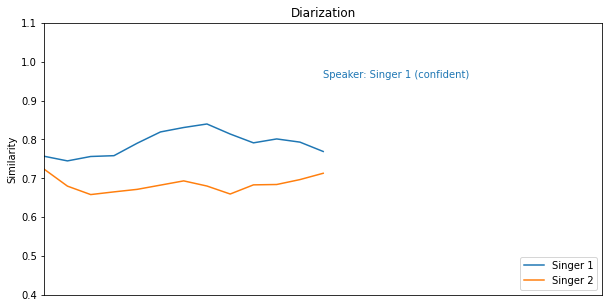

In [8]:
interactive_diarization(similarity_dict, wav_splits)

In [5]:
print(f"Starting in... ", end='')

for t in (3, 2, 1):
    print(f"{t} ", end='')
    sleep(1)
print("START")
play_wav(wav_both_speakers, blocking=False)

Starting in... 3 2 1 START


In [6]:
import uisrnn

sys.argv = ['dummy']
model_args, training_args, inference_args = uisrnn.parse_arguments()

In [7]:

wav = preprocess_wav("Resemblyzer/audio_data/X2zqiX6yL3I.mp3")
# wav = preprocess_wav("imitation_game.wav")

speaker_names = [f"Speaker {k}" for k in range(4)]

print("Running the continuous embedding on cpu, this might take a while...")
_, cont_embeds, wav_splits = encoder.embed_utterance(wav, return_partials=True, rate=embed_rate)


/Users/brauliorios/.pyenv/versions/3.7.6/envs/audio/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Running the continuous embedding on cpu, this might take a while...


In [9]:
model = uisrnn.UISRNN(model_args)

model.load('uis-rnn/saved_model.uisrnn')

# Testing
test_sequence = cont_embeds.astype(float)
predictions = model.predict(test_sequence, inference_args)


In [10]:
# Get the continuous similarity for every speaker. It amounts to a dot product between the 
# embedding of the speaker and the continuous embedding of the interview
similarity_dict = {name: (np.array(predictions) == speaker_id).astype(int) for speaker_id, name, speaker_embed in 
                   zip(range(len(speaker_names)), speaker_names, speaker_embeds)}



In [11]:
interactive_diarization(similarity_dict, wav_splits)

TypeError: interactive_diarization() missing 1 required positional argument: 'wav_splits'

In [ ]:
print(f"Starting in... ", end='')

for t in (3, 2, 1):
    print(f"{t} ", end='')
    sleep(1)
print("START")
play_wav(wav, blocking=False)